In [1]:
import pandas as pd
import numpy as np

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import seaborn as sns

from data import VantilatorDataModule

from unet import UNet
from lstm import LSTM

<br><br><br><br>

## EDA

In [2]:
DATA_PATH = 'D:/data/ventilator-pressure-prediction/'

train_data = pd.read_csv(DATA_PATH+'train.csv',index_col=0)
test_data  = pd.read_csv(DATA_PATH+'test.csv', index_col=0)
sample     = pd.read_csv(DATA_PATH+'sample_submission.csv')

C:\Users\codef\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<br>Not all the series have the same sampling rate:

In [4]:
lengths = train_data.groupby("breath_id")["time_step"].max()
lengths.min(), lengths.max()

(2.4968085289001465, 2.9372379779815674)

In [5]:
def plot_hist(x, ylim, xlim, title, bins=5000):

    fig, ax = plt.subplots(1,1,figsize=(30,3))

    plt.hist(x, density=True, bins=bins)
    plt.ylabel('density')
    plt.xlabel('time in seconds')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)

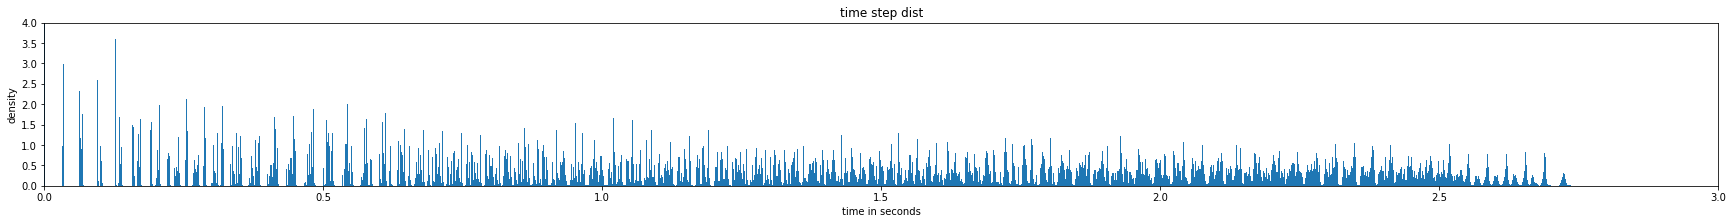

In [6]:
plot_hist(train_data.time_step, (0,4), (0,3), 'time step dist')

There are like around 10 final time step groups, maybe one per R and C combination.

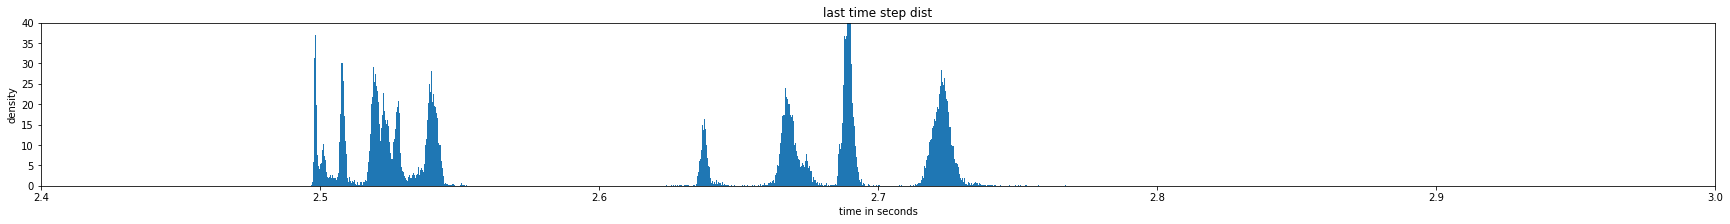

In [7]:
plot_hist(train_data.groupby("breath_id")["time_step"].max().values, (0,40), (2.4,3), 'last time step dist')

<br><br><br><br>

## Predictions

In [8]:
data = VantilatorDataModule(dataset='train')

100%|██████████| 129/129 [00:30<00:00,  4.29it/s]


In [ ]:
device = 'cuda'

In [9]:
model_unet = UNet.load_from_checkpoint('./checkpoints/UNET_CV50.ckpt', n_channels=data.series_input.shape[1])
model_lstm = LSTM.load_from_checkpoint('./checkpoints/LSTM_CV50.ckpt', n_channels=data.series_input.shape[1])

model_unet.to(device)
model_lstm.to(device)

model_unet.eval()
model_lstm.eval()

inputs = []
output_unet = []
output_lstm = []

for idx, batch in enumerate(data.data_loader_test):

    inputs.append(batch[0])
    output_unet.append( model_unet(batch[0].to(device)).detach().cpu().numpy().squeeze() )
    output_lstm.append( model_lstm(batch[0].to(device)).detach().cpu().numpy().squeeze() )

inputs = np.vstack(inputs)
output_unet = np.vstack(output_unet)
output_lstm = np.vstack(output_lstm)

# The output of the models are rescaled to the original sampling:
preds_unet = (output_unet.flatten()[data.indices.astype(bool).flatten()].reshape((-1, 80)))
preds_lstm = (output_lstm.flatten()[data.indices.astype(bool).flatten()].reshape((-1, 80)))

# The targets used for the training are rescaled to the original sampling:
targets = (data.series_target.flatten()[data.indices.astype(bool).flatten()].reshape((-1, 80)))
# Once rescaled, it should be similar to the original values
assert((targets != data.pressure).sum() == 0)

C:\Users\codef\anaconda3\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
inputs.shape, preds_unet.shape, targets.shape

((75450, 16, 128), (75450, 80), (75450, 80))

In [11]:
print('U-Net mean MAE:', np.mean(np.mean(np.abs(preds_unet - targets), axis=1)))
print('LSTM mean MAE: ', np.mean(np.mean(np.abs(preds_lstm - targets), axis=1)))

U-Net mean MAE: 0.2731893
LSTM mean MAE:  0.2631968


In [12]:
# Values are sorted by prediction error size:

maes_lstm = np.mean(np.abs(preds_lstm - targets), axis=1)
sort_idx_lstm = np.argsort(maes_lstm)[::-1]

maes_unet = np.mean(np.abs(preds_unet - targets), axis=1)
sort_idx_unet = np.argsort(maes_unet)[::-1]

In [13]:
# indices of series sorted by prediction error (LSTM)
sort_idx_lstm, maes_lstm[sort_idx_lstm]

(array([72145, 27667,   133, 44851, 71850, 64262, 40075, 42306, 38284, 45622, 38349, 14108,  7668, 65863,
         8440, 46247, 10303, 46661, 26231, 68724, ..., 37749, 74028, 39881, 24251, 36372,  1990,  9168, 49987,
        41099, 43910,  8589, 68191, 17646, 65472, 56083, 17186,  2778,  8625, 49954, 28299], dtype=int64),
 array([13.5673, 10.3309,  5.2357,  5.0496,  2.395 ,  2.3691,  2.2372,  2.0973,  2.0483,  2.0121,  1.9805,
         1.9683,  1.968 ,  1.9615,  1.9605,  1.944 ,  1.9367,  1.9324,  1.9202,  1.9186, ...,  0.0687,
         0.0686,  0.0684,  0.0684,  0.0682,  0.0682,  0.0681,  0.068 ,  0.068 ,  0.0676,  0.0673,  0.0671,
         0.0665,  0.0653,  0.0645,  0.0641,  0.064 ,  0.0619,  0.0576,  0.0547], dtype=float32))

In [14]:
# indices of series sorted by prediction error (UNET)
sort_idx_unet, maes_unet[sort_idx_unet]

(array([72145, 27667,   133, 44851, 71850, 64262, 40075, 27645, 42306, 63090, 33731, 66869, 27443, 29650,
        65896, 67979, 72269, 32575, 27665, 24180, ..., 19252, 35771, 23166, 20572, 45372, 21111, 15622, 17652,
        74819, 39338, 35451, 32771, 63667,  7559, 20259, 24342, 68052, 66171, 25774, 15720], dtype=int64),
 array([12.9401,  5.9868,  5.3426,  2.9817,  2.2714,  2.1905,  2.1864,  2.1695,  2.1461,  2.0621,  1.8827,
         1.8624,  1.8436,  1.8414,  1.8385,  1.8325,  1.8281,  1.8215,  1.8175,  1.8122, ...,  0.0798,
         0.0796,  0.0794,  0.079 ,  0.0784,  0.0783,  0.0771,  0.0771,  0.0769,  0.0761,  0.0761,  0.076 ,
         0.0757,  0.0754,  0.0754,  0.0732,  0.0727,  0.072 ,  0.0711,  0.0688], dtype=float32))

In [18]:
p = sns.color_palette()

def plot_preassure(idx):

    fig, ax = plt.subplots(1,1,figsize=(15,3))

    ax.plot(list(range(80)), targets[idx], color=p[0], alpha=0.6, linestyle='--')
    ax.plot(list(range(80)), preds_unet[idx], color=p[1])
    ax.plot(list(range(80)), preds_lstm[idx], color=p[2])

    ax.legend(labelcolor=p[:3], labels=['target', 'unet', 'lstm'], loc ="upper right")
    ax.axvline(34, alpha=0.5, linestyle='--', color='gray', linewidth=0.7)

    plt.ylabel('preassure')
    plt.xlabel('time')
    plt.ylim(-3,45)

<br>20 series with the largest LSTM model error:

<ipython-input-15-37c3b283202d>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1,figsize=(15,3))


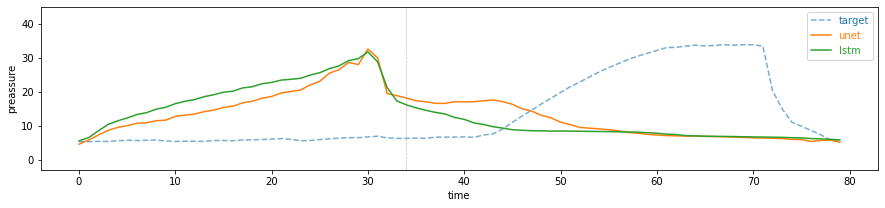

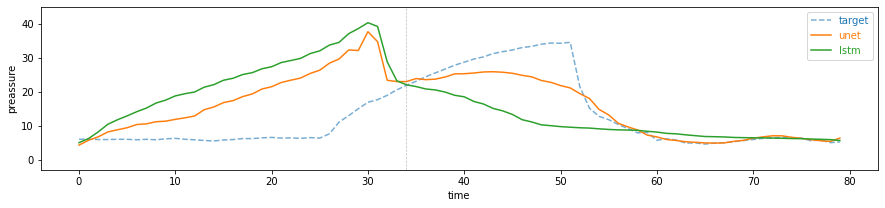

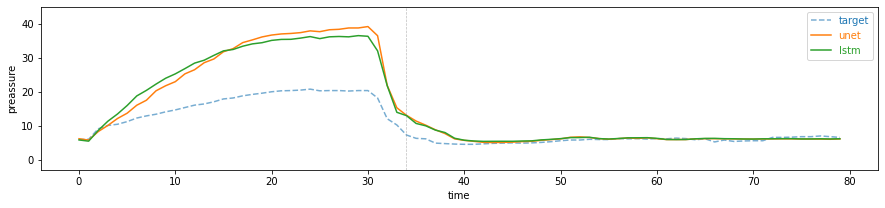

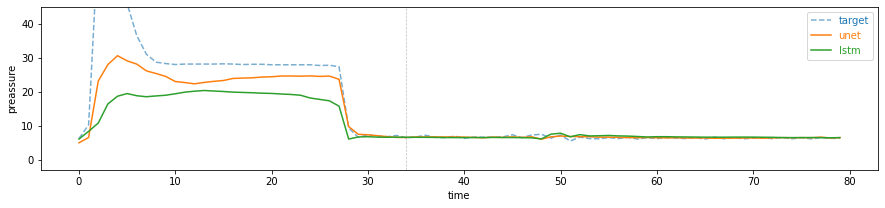

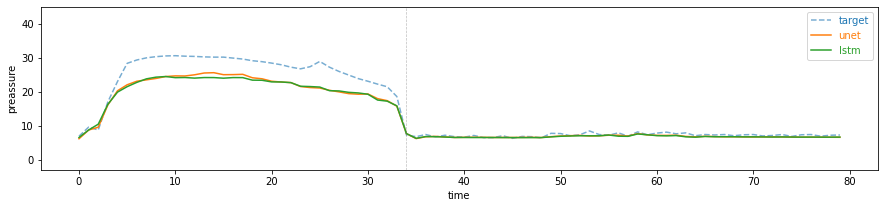

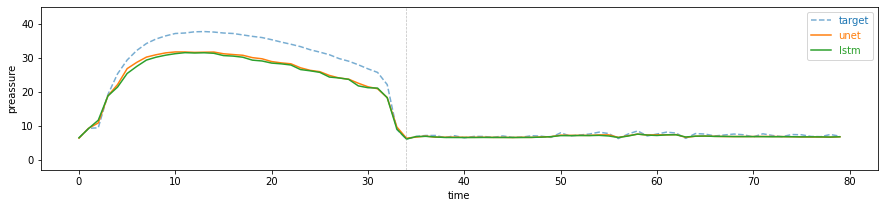

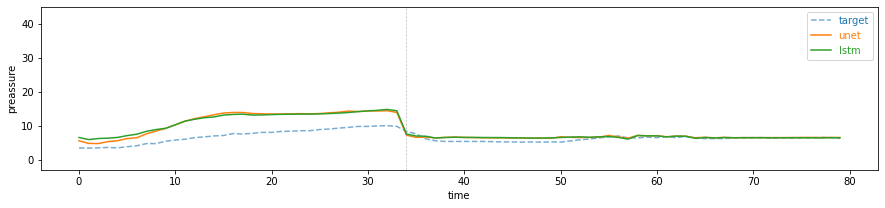

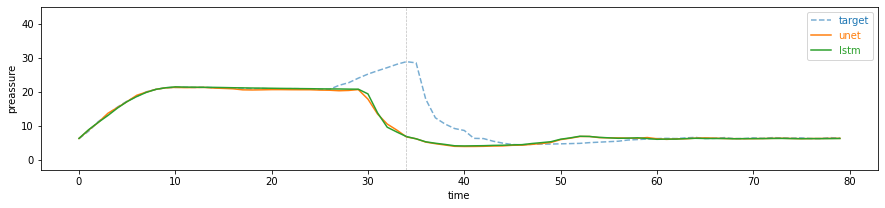

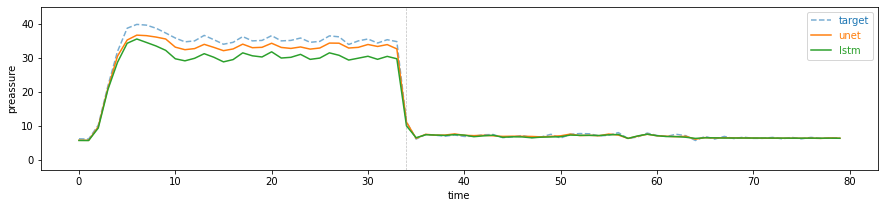

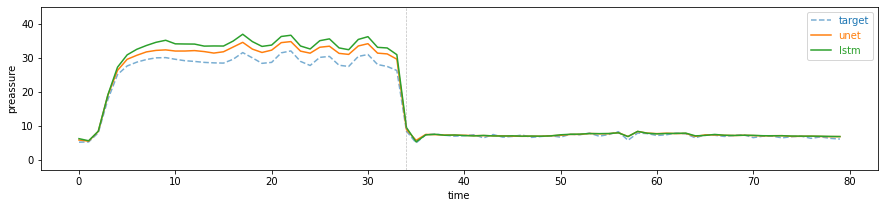

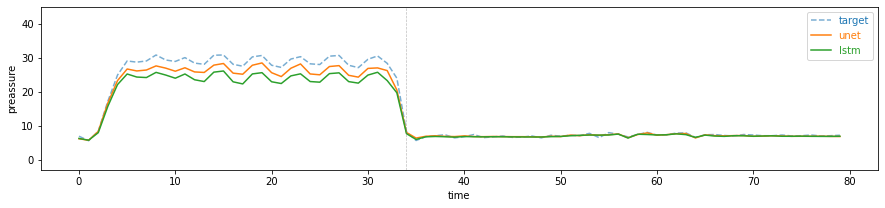

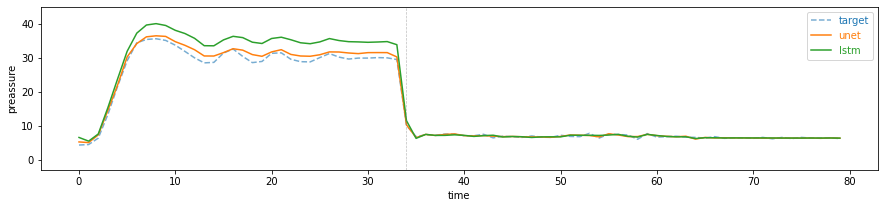

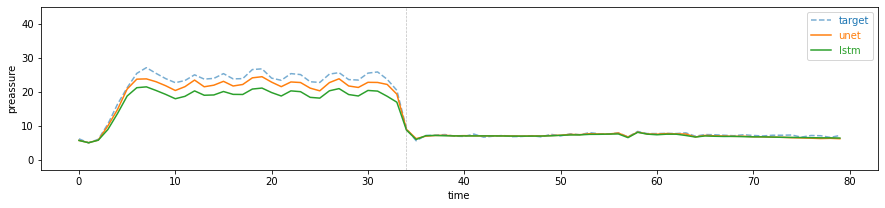

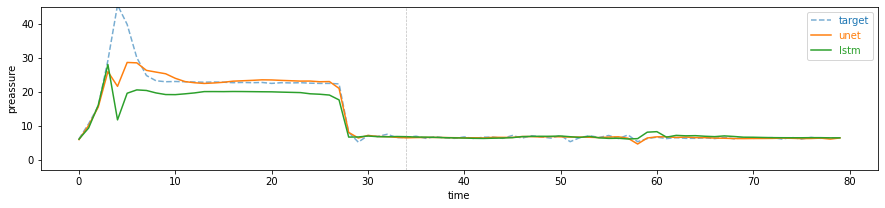

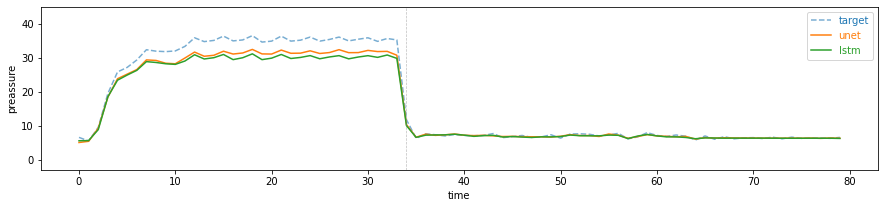

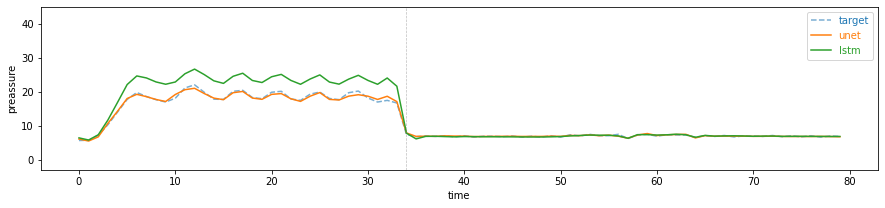

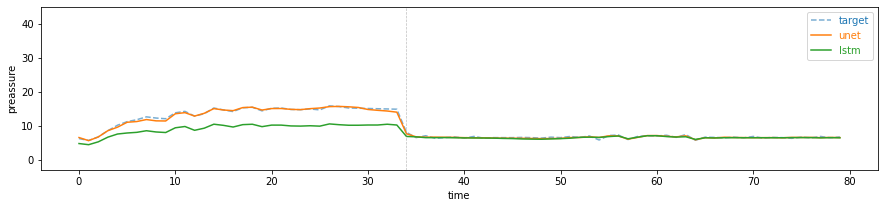

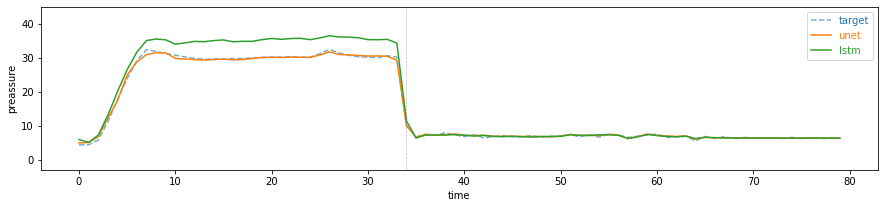

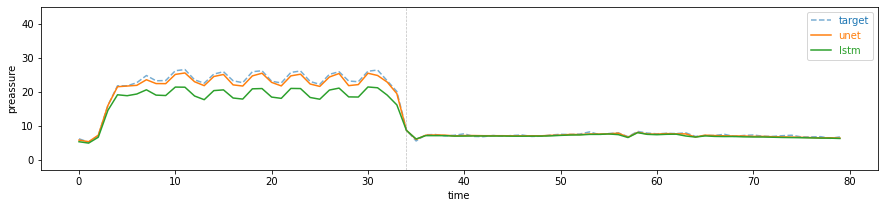

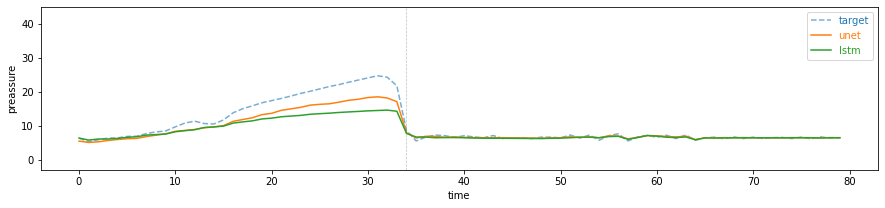

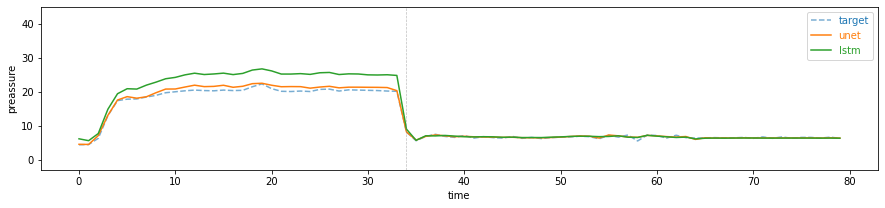

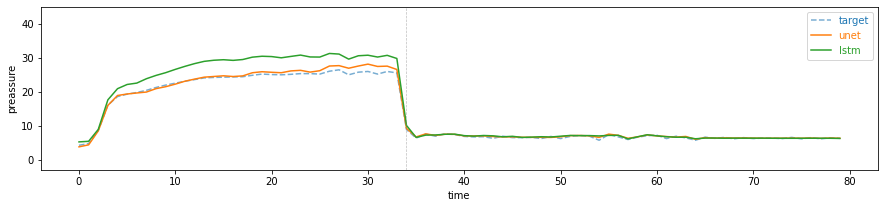

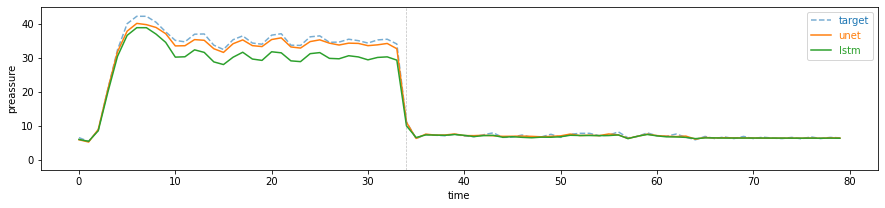

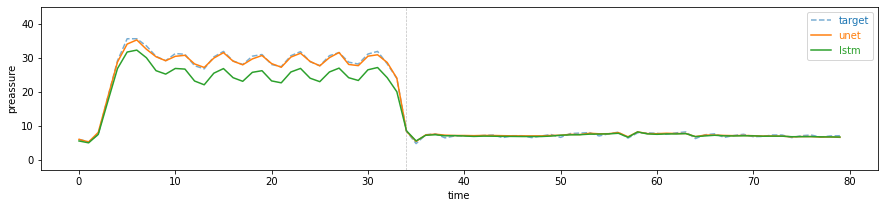

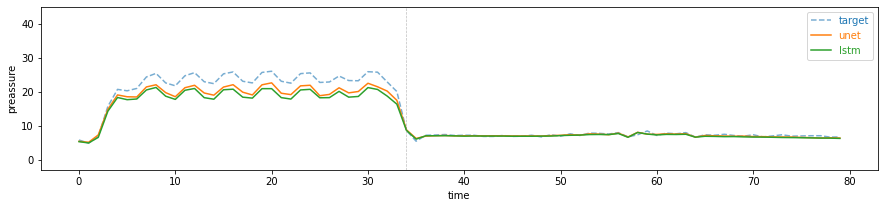

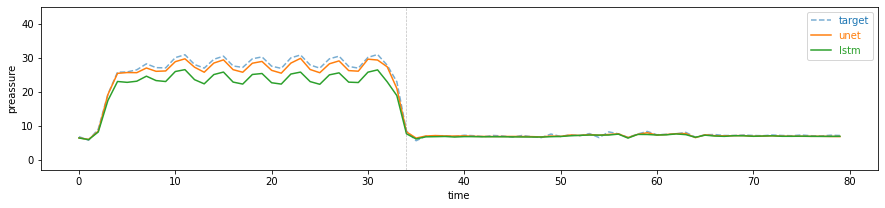

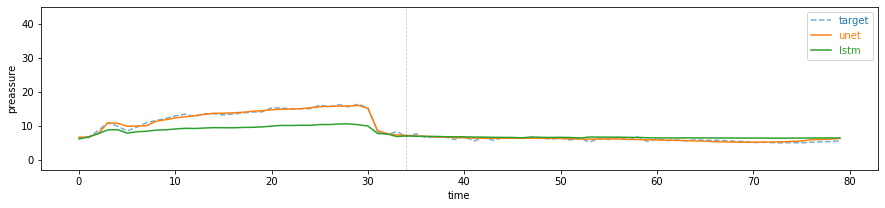

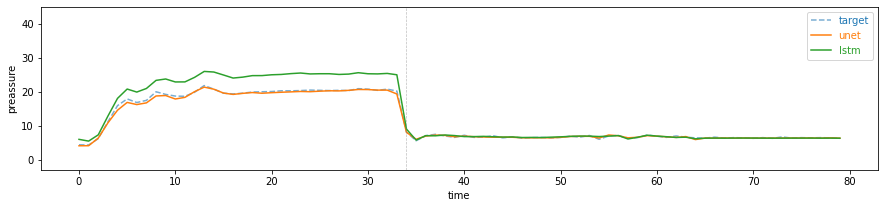

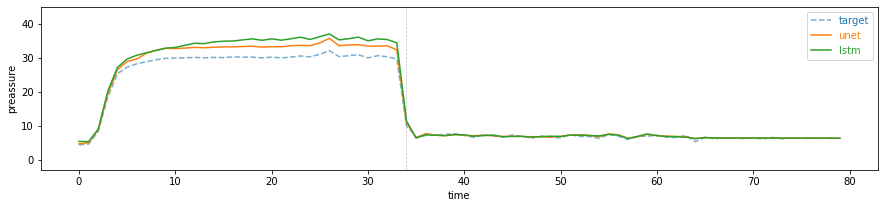

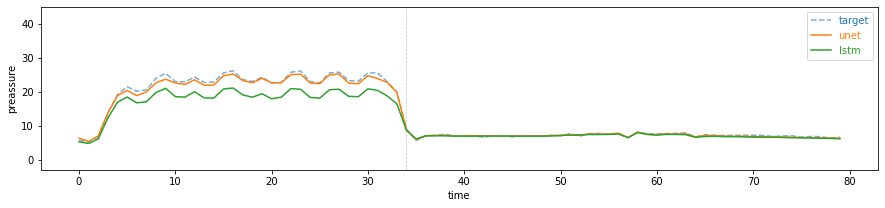

In [16]:
for i in range(20):
    plot_preassure(sort_idx_lstm[i])

<br>50 series with the largest UNET model error:

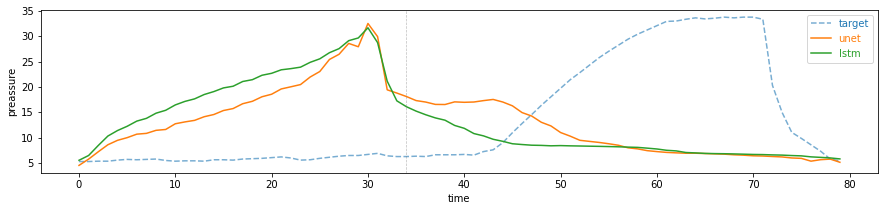

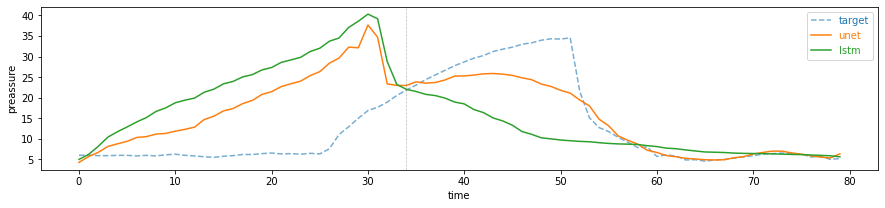

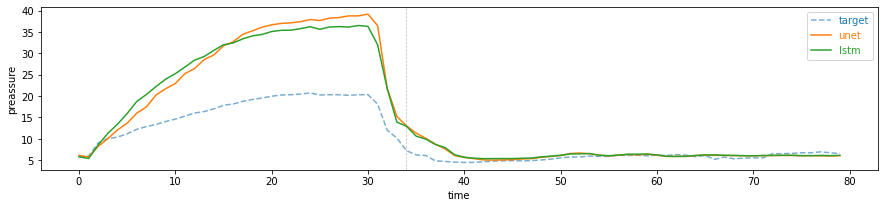

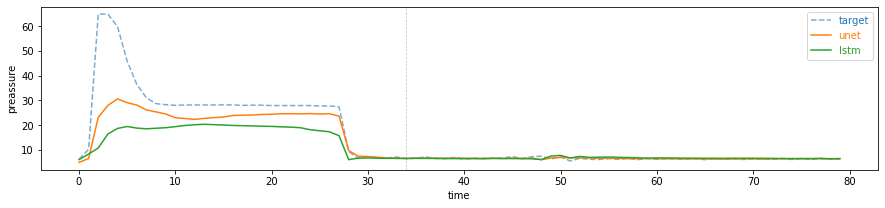

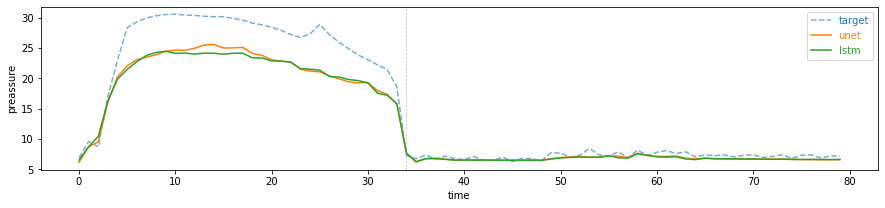

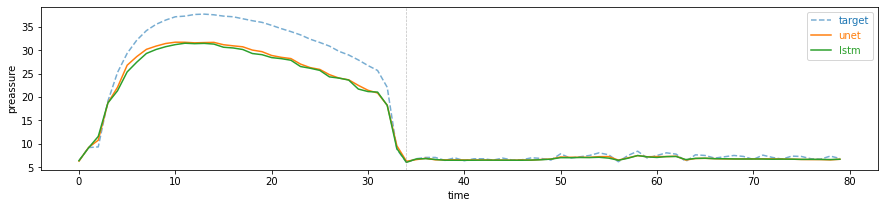

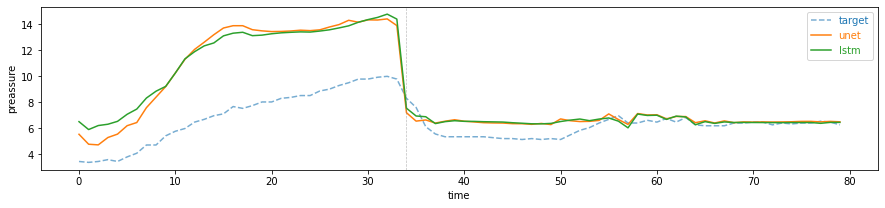

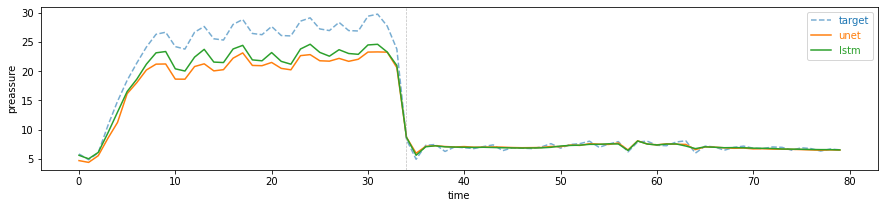

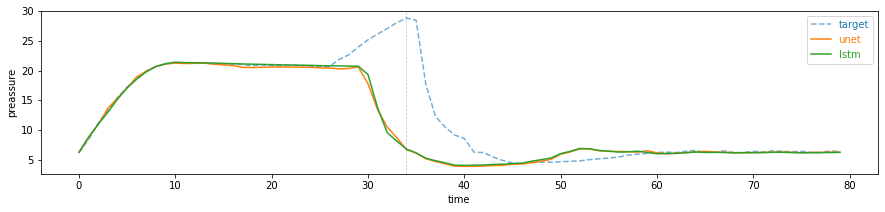

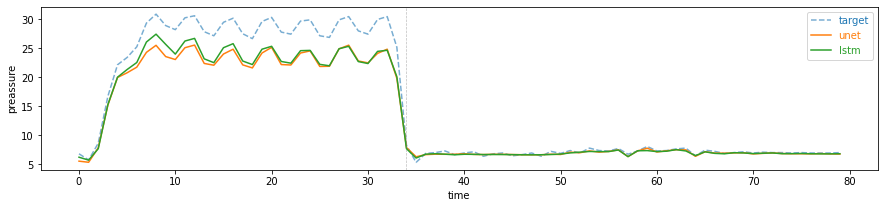

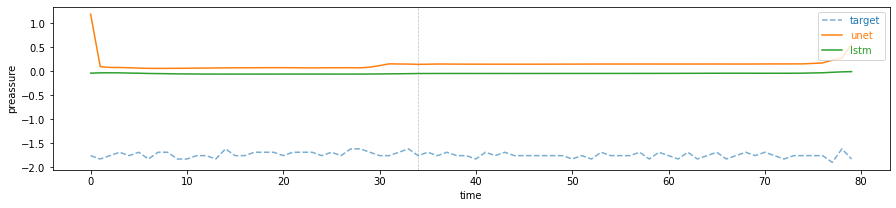

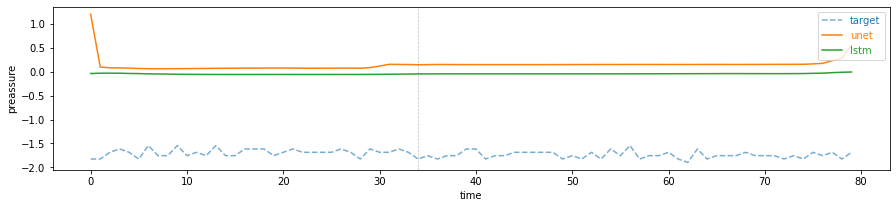

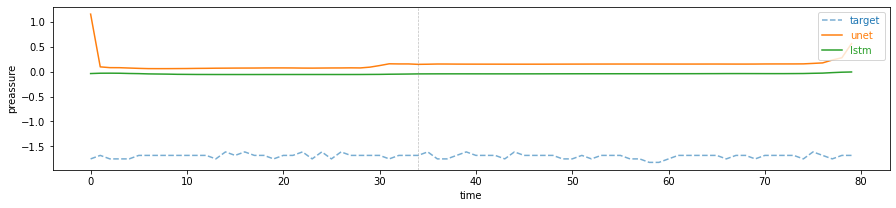

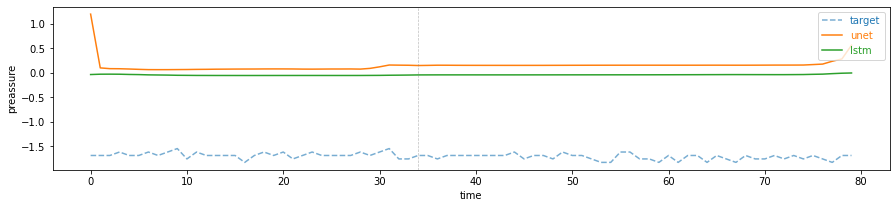

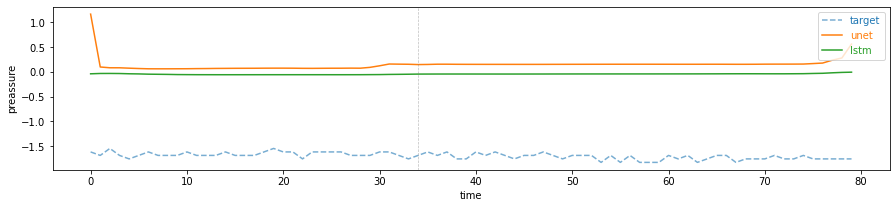

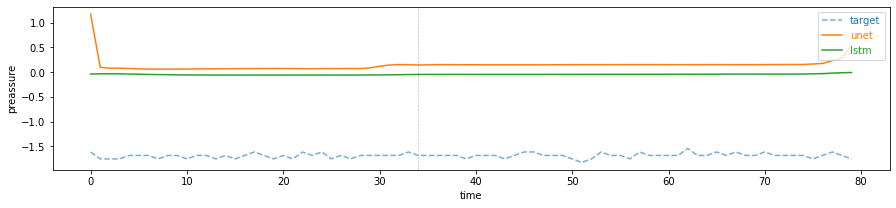

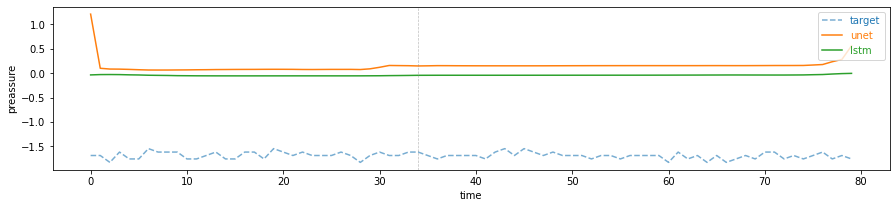

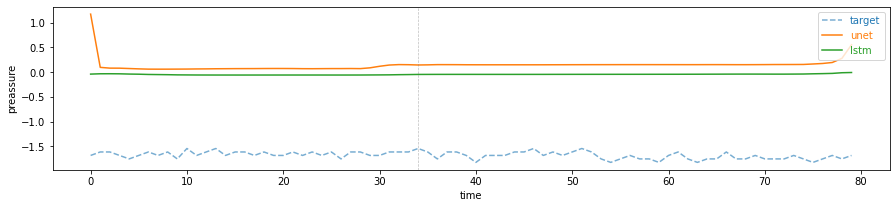

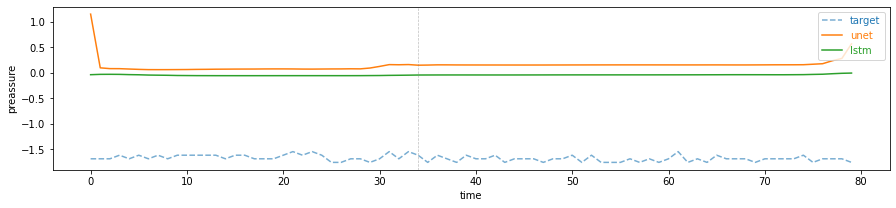

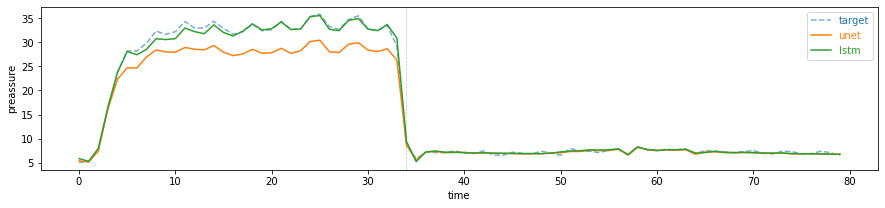

In [19]:
for i in range(20):
    plot_preassure(sort_idx_unet[i])